In [14]:
from __future__ import absolute_import, division, print_function
from tqdm import tqdm   

from termcolor import colored
import tensorflow as tf
import os                   # work with directories
import numpy as np          # dealing with arrays
import matplotlib.pyplot as plt
import time
import pickle as pk
import random
import sys
import cv2
from tensorflow.python.client import device_lib
tfe = tf.contrib.eager

from tensorflow.python.eager import tape


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
layers = tf.keras.layers
tf.enable_eager_execution(config=config)
tf.executing_eagerly()
print(tf.__version__)


import platform
machine_type = platform.uname()[0]
if machine_type == 'Linux':
    path_sep = '/'
else:
    path_sep = '\win'
HOME_DIR = os.getcwd()
MAIN_dir = HOME_DIR + path_sep+'Cleaned_code'+path_sep+'Shared_git'+path_sep
checkpoint_path = MAIN_dir + 'checkpoints'+path_sep
data_files_path = MAIN_dir + 'data_files'+path_sep
mean_path = data_files_path + 'std_mean_60_dataset.npy'
dataset_path = MAIN_dir + 'dataset'+path_sep
tensorboard_path = MAIN_dir + 'tensorboard'+path_sep

1.12.0


In [15]:

filename = 'sample_set.pickle'
pickle_in_sample = open(MAIN_dir + 'data_files/' + filename, "rb")
sample_data = pk.load(pickle_in_sample)
pickle_in_sample.close()

images_s = sample_data['images']
labels_s = sample_data['labels']
speeds_s = sample_data['speeds']
log_length_s = sample_data['log_length']


ch1_mean 97.59649670930388 mean= 62.383118295426804  std=  51.31584701596993
  /home/moe/Desktop/bambo_Logs/Data/my_dataset/testing/2015_08_12_1728_bamb_night_44_623/Image_0_0_01702.520.bmp   [623.]   [2.024726]   [24.83804]   362.0 15529 


(70002,) (70002, 1) (70002, 1) (70002, 1) (70002,)


In [16]:
Batch_size = 8
Buffer_size = 8
Epochs = 100

sample_dataset = tf.data.Dataset.from_tensor_slices((images_s, labels_s, speeds_s, log_length_s))
sample_dataset = sample_dataset.batch(Batch_size)
sample_dataset = sample_dataset.prefetch(Batch_size)




In [ ]:
# LOAD RES-9ER - default
from Cleaned_code.Shared_git import RES_9ER as Res9

# Instantiate the model and configure tensorbaord and checkpoints
data_format = 'channels_last'
model = Res9.Res9ER(data_format=data_format, include_top=True, pooling=None, classes=1)
optimizer = tf.train.AdamOptimizer()
accuracy = 0 
acc_prediction = tf.constant(0, dtype="float32")
t = tf.constant(1/7.5, dtype="float32")
loss = tf.constant(0, dtype="float32")
logdir = tensorboard_path
loc_checkpoint_path = checkpoint_path+'generated_checkpoints/'+"cp-{log:06d}.ckpt"
checkpoint_dir = os.path.dirname(loc_checkpoint_path)
summary_writer = tf.contrib.summary.create_file_writer(logdir)


In [ ]:
# LOAD checkpoint if you wish to test results
checkpoint_name = 'RES_9ER'
model.load_weights(checkpoint_path+checkpoint_name)

In [ ]:
def compute_loss(prediction, label, train_log_length_, operation='L2'):
    if operation == 'L2':
        return tf.divide(tf.squared_difference(prediction, label), train_log_length_)
    elif operation == 'Subtraction':
        return tf.divide(tf.subtract(prediction, label), train_log_length_)
    elif operation == 'L1':
        return tf.divide(tf.abs(tf.subtract(prediction, label)), train_log_length_)
    else:
        raise ValueError('Please specify loss function (L2, L1, Subtraction)')


def print_progress(count, total, cnt, overall, time_, count_log, loss, loss_):
    percent_complete = float(count) / total
    overall_complete = float(cnt) / (overall-1)

    sec = time_ % 60
    mint = int(time_/60) % 60
    hr = int(time_/3600) % 60
    loss = str(loss)
    loss_ = str(loss_)
    msg = "\r Time_lapsed (hr:mm:ss) --> {0:02d}:{1:02d}:{2:02d} ,   loss: {3:s}   Log Progress: {4:.1%},     Overall Progress:{5:.1%}," \
        " completed {6:d} out of 185 logs <--> Initial loss: {7:s} ".format(hr, mint, sec, loss, percent_complete, overall_complete, count_log, loss_)
    sys.stdout.write(msg)
    sys.stdout.flush()
    

def validation_progress(log_cnt, num_logs, time_, loss, accuracy_loc):
    log_cnt += 1
    overall_complete = float(log_cnt) / num_logs
    sec = int(time_) % 60
    mint = int(time_/60) % 60
    hr = int(time_/3600) % 60
    loss = str(loss)
    msg = "\r Validation_Time (hr:mm:ss) --> {0:02d}:{1:02d}:{2:02d} ,   Avg_loss: {3:s}   Avg_accuracy: {4:.2%}   Overall Progress:{5:.1%}," \
        " completed {6:d} out of {7:d} logs".format(hr, mint, sec, loss, accuracy_loc, overall_complete, log_cnt, num_logs)
    sys.stdout.write(colored(msg, 'green'))
    sys.stdout.flush()


def write_summaries(loss, i, global_step, vars_loc, grads_loc, train=True):
    with summary_writer.as_default():
        with tf.contrib.summary.always_record_summaries():
            if train:
                tf.contrib.summary.scalar("train_loss", loss, step=global_step)
                tf.contrib.summary.scalar("step", i, step=global_step)
                #  do not add spaces after names
                tf.contrib.summary.histogram("weights", vars_loc, step=global_step)
                tf.contrib.summary.histogram("gradients", grads_loc, step=global_step)
            else:
                tf.contrib.summary.scalar("val_loss", loss, step=global_step)
                





In [18]:
# VALIDATION CODE

def validate_model(model_loc, val_step_, n_logs, data_set, write_summary=True, return_losses=True):
    logs_N = n_logs
    start = time.time()
    MAE = []
    MSE = []
    MSBE = []
    log_order = []
    Accuracy = []
    metric_mse = []
    summed_volume = 0
    remainder = 0
    iterations = 0
    fixed_size = 0
    count = 0
    new_log = True
    cnt_log = -1
    signal = []
    signals = [] 
    for (batch, (image, label, speed, lengths)) in (enumerate(data_set)):
        size = np.shape(label)[0]
        labels = tf.reshape(label, [size, 1])
        speeds = tf.reshape(speed, [size, 1])
        log_length = tf.squeeze(lengths)
        images = tf.squeeze(image)
        batch += 1
        if new_log:           
            new_log = False
            length = int(log_length[0].numpy() - fixed_size + remainder)
            iterations = int(np.floor(length/Batch_size))
            remainder = int(np.mod(length, Batch_size))
            fixed_size = np.shape(speeds)[0]
            cnt_log += 1

        if count < iterations:
            mass_pred = model_loc(images)
            volume = (mass_pred * speeds) * t
            summed_volume += tf.reduce_sum(volume)
            mass = np.abs(summed_volume.numpy())
            count = count + 1
            signal.append(volume)
            # Compute loss
            if count == iterations and remainder == 0:
                loss_unsigned = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
                loss_outlier = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L1').numpy())
                loss_signed = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction').numpy())
                MSE.append(loss_unsigned)
                MAE.append(loss_outlier)
                MSBE.append(loss_signed)
                signals.append(signal[0:len(signal)])
                signal.clear()
        
                gt = np.squeeze(labels[0].numpy())
                metric_mse.append(loss_unsigned)
                
                tmp = np.abs(gt - mass)
                tmp = tmp / gt
                log_acc = 1 - np.squeeze(tmp)
                    
                Accuracy.append(log_acc)
                log_order.append(np.squeeze(log_length[0].numpy()))
                time_ = time.time() - start
                validation_progress(cnt_log, logs_N, time_, np.mean(metric_mse), np.mean(Accuracy))
                if write_summary:
                    write_summaries(np.mean(MSE), 0, val_step_, 0, 0, train=False)
                val_step_ += 1
                # Reset
                summed_volume = 0
                count = 0
                fixed_size = 0
                new_log = True
        # Handle the remainder from iterations
        else:
            # Compute and Aggregate the remainder Gradients
            mass_pred = model(images[0:remainder])
            volume = (mass_pred * speeds[0:remainder]) * t
            summed_volume += tf.reduce_sum(volume)
            mass = np.abs(summed_volume.numpy())
            signal.append(volume)
            
            loss_unsigned = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
            loss_outlier = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L1').numpy())
            loss_signed = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction').numpy())
            MSE.append(loss_unsigned)
            MAE.append(loss_outlier)
            MSBE.append(loss_signed)
            signals.append(signal[0:len(signal)])
            signal.clear()
            
            gt = np.squeeze(labels[0].numpy())
            metric_mse.append(loss_unsigned)

            tmp = np.abs(gt - mass)
            tmp = tmp / gt
            log_acc = 1 - np.squeeze(tmp)
            
            Accuracy.append(log_acc)
            log_order.append(np.squeeze(log_length[0].numpy()))
            time_ = time.time() - start
            validation_progress(cnt_log, logs_N, time_, np.mean(metric_mse), np.mean(Accuracy))  
            
            if write_summary:  
                write_summaries(np.mean(MSE), 0, val_step_, 0, 0, train=False)
            val_step_ += 1
            summed_volume = 0
            count = 0
            new_log = True
            
            # Handle gradients for the next log
            if cnt_log != logs_N-1:    
                mass_pred = model(images[remainder:])
                volume = (mass_pred * speeds[remainder:]) * t
                summed_volume += tf.reduce_sum(volume)
                signal.append(volume)
                
    if return_losses:
        return MSE, MAE, MSBE, Accuracy, val_step_
    else: 
        return signals

In [20]:
model.load_weights(MAIN_dir+'checkpoints/cp-0081nbrt9_95.ckpt')

In [31]:
model.load_weights(MAIN_dir+'checkpoints/cp-0100_nomask.ckpt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


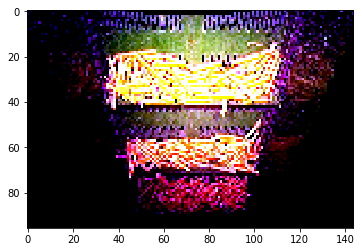

In [32]:
for (batch, (images, labels, speeds, log_length)) in enumerate(train_dataset):
    if batch == 450:
        x = tf.image.convert_image_dtype(images[0], tf.uint8, saturate=True)
        # x2 = tf.cast(images[0], tf.uint8)
        plt.imshow(images[0])
        # print(images[0])
        # print(np.min(images[0], np.max(images[0])))
        # plt.imshow(images[0])
        # print(images[0].numpy().shape)
        # print(np.shape(images[0])[0])
        break

In [21]:

def visualize(img, cam, filename,gb_viz):
    gb_viz = np.dstack((
            gb_viz[:, :, 2],
            gb_viz[:, :, 1],
            gb_viz[:, :, 0],
        ))

    gb_viz -= np.min(gb_viz)
    gb_viz /= gb_viz.max()
  
    fig, ax = plt.subplots(nrows=1,ncols=3)

    plt.subplot(141)
    plt.axis("off")
    imgplot = plt.imshow(img)

    plt.subplot(142)
    gd_img = gb_viz*np.minimum(0.25,cam).reshape(96, 144, 1)
    x = gd_img
    x = np.squeeze(x)
    
    #normalize tensor
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
   
    x = np.clip(x, 0, 255).astype('uint8')

    plt.axis("off")
    imgplot = plt.imshow(x, vmin = 0, vmax = 20)

    cam = (cam*-1.0) + 1.0
    cam_heatmap = np.array(cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET))
    plt.subplot(143)
    plt.axis("off")

    imgplot = plt.imshow(cam_heatmap)

    plt.subplot(144)
    plt.axis("off")
    
    cam_heatmap = cam_heatmap/255.0

    fin = (img*0.7) + (cam_heatmap*0.3)
    imgplot = plt.imshow(fin)

    plt.savefig(filename, dpi=600)
    plt.close(fig)



In [69]:

def visualize_mod(img, cam, filename,gb_viz):
    gb_viz = np.dstack((
            gb_viz[:, :, 2],
            gb_viz[:, :, 1],
            gb_viz[:, :, 0],
        ))

    gb_viz -= np.min(gb_viz)
    gb_viz /= gb_viz.max()
  
    fig, ax = plt.subplots(nrows=1,ncols=3)

    plt.subplot(121)
    plt.axis("off")
    imgplot = plt.imshow(img)

    # plt.subplot(142)
    # gd_img = gb_viz*np.minimum(0.25,cam).reshape(96, 144, 1)
    # x = gd_img
    # x = np.squeeze(x)

    #normalize tensor
    # x -= x.mean()
    # x /= (x.std() + 1e-5)
    # x *= 0.1
    # 
    # # clip to [0, 1]
    # x += 0.5
    # x = np.clip(x, 0, 1)
    # 
    # # convert to RGB array
    # x *= 255
    # 
    # x = np.clip(x, 0, 255).astype('uint8')

    # plt.axis("off")
    # imgplot = plt.imshow(x, vmin = 0, vmax = 20)

    cam = (cam*-1.0) + 1.0
    cam_heatmap = np.array(cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET))
    # plt.subplot(143)
    plt.axis("off")

    # imgplot = plt.imshow(cam_heatmap)

    plt.subplot(122)
    plt.axis("off")
    
    cam_heatmap = cam_heatmap/255.0

    fin = (img*0.7) + (cam_heatmap*0.3)
    imgplot = plt.imshow(fin)

    plt.savefig(filename, dpi=600)
    plt.close(fig)



In [39]:
# VALIDATION CODE


def validate_model(model_loc, val_step_, n_logs, data_set, write_summary=True, return_losses=True, conv_out=False):
    logs_N = n_logs
    start = time.time()
    MAE = []
    MSE = []
    MSBE = []
    log_order = []
    Accuracy = []
    metric_mse = []
    summed_volume = 0
    remainder = 0
    iterations = 0
    fixed_size = 0
    count = 0
    new_log = True
    cnt_log = -1
    signal = []
    signals = []
    for (batch, (images, labels, speeds, log_length)) in enumerate(data_set):
        batch += 1
        if new_log:           
            new_log = False
            length = int(log_length[0].numpy() - fixed_size + remainder)
            iterations = int(np.floor(length/Batch_size))
            remainder = int(np.mod(length, Batch_size))
            fixed_size = np.shape(speeds)[0]
            cnt_log += 1

        if count < iterations:
            mass_pred, layer = model_loc(images, conv_out=True)
            volume = (mass_pred * speeds) * t
            summed_volume += tf.reduce_sum(volume)
            mass = np.abs(summed_volume.numpy())
            count = count + 1
            signal.append(volume)
            # Compute loss
            if count == iterations and remainder == 0:
                loss_unsigned = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
                loss_outlier = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L1').numpy())
                loss_signed = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction').numpy())
                MSE.append(loss_unsigned)
                MAE.append(loss_outlier)
                MSBE.append(loss_signed)
                signals.append(signal[0:len(signal)])
                signal.clear()
        
                gt = np.squeeze(labels[0].numpy())
                if gt >= 200 and gt != 501:  # used for testing
                    metric_mse.append(loss_unsigned)
                    
                    # if mass > gt:
                    #     log_acc = np.squeeze(gt/mass)
                    # else:
                    #     log_acc = np.squeeze(mass/gt)
                        
                    tmp = np.abs(gt - mass)
                    tmp = tmp / gt
                    log_acc = 1 - np.squeeze(tmp)
                        
                    Accuracy.append(log_acc)
                    log_order.append(np.squeeze(log_length[0].numpy()))
                    time_ = time.time() - start
                    validation_progress(cnt_log, logs_N, time_, np.mean(metric_mse), np.mean(Accuracy))
                if write_summary:
                    write_summaries(np.mean(MSE), 0, val_step_, 0, 0, train=False)
                val_step_ += 1
                # Reset
                summed_volume = 0
                count = 0
                fixed_size = 0
                new_log = True
        # Handle the remainder from iterations
        else:
            # Compute and Aggregate the remainder Gradients
            mass_pred, layer = model(images[0:remainder], conv_out=conv_out)
            volume = (mass_pred * speeds[0:remainder]) * t
            summed_volume += tf.reduce_sum(volume)
            mass = np.abs(summed_volume.numpy())
            signal.append(volume)
            
            loss_unsigned = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
            loss_outlier = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L1').numpy())
            loss_signed = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction').numpy())
            MSE.append(loss_unsigned)
            MAE.append(loss_outlier)
            MSBE.append(loss_signed)
            signals.append(signal[0:len(signal)])
            signal.clear()
            
            gt = np.squeeze(labels[0].numpy())
            if gt >= 200 and gt != 501:  # used for testing
                metric_mse.append(loss_unsigned)
                
                # 
                # if mass > gt:
                #     log_acc = np.squeeze(gt/mass)
                # else:
                #     log_acc = np.squeeze(mass/gt)
               
                tmp = np.abs(gt - mass)
                tmp = tmp / gt
                log_acc = 1 - np.squeeze(tmp)
                
                
                Accuracy.append(log_acc)
                log_order.append(np.squeeze(log_length[0].numpy()))
                time_ = time.time() - start
                validation_progress(cnt_log, logs_N, time_, np.mean(metric_mse), np.mean(Accuracy))  
            
            if write_summary:  
                write_summaries(np.mean(MSE), 0, val_step_, 0, 0, train=False)
            val_step_ += 1
            summed_volume = 0
            count = 0
            new_log = True
            
            # Handle gradients for the next log
            if cnt_log != logs_N-1:    
                mass_pred, layer = model(images[remainder:], conv_out=conv_out)
                volume = (mass_pred * speeds[remainder:]) * t
                summed_volume += tf.reduce_sum(volume)
                signal.append(volume)
                
    if return_losses:
        return MSE, MAE, MSBE, Accuracy, val_step_
    else: 
        return signals

gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image

gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image

gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image shape (96, 144, 3)
gb shape (96, 144, 3) cam shape (480, 720) image

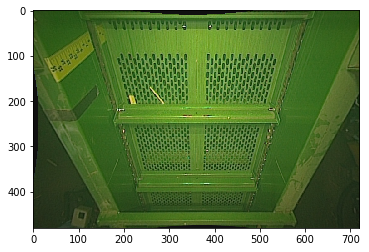

In [87]:
# TRAINING CODE
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
save_epoch = 1
loss_ = 0
logs_N = 143
start = time.time()
aggregated = []
MSE_log = []
MAE_log = []
MSBE_log = []
MSE_t = []
MAE_t = []
MSBE_t = []
MSE_avg = []
MAE_avg = []
MSBE_avg = []
MSE_train = []
val_step = 1
run_name = 'ELU_Shaped_40_noBatch_12'
performance_flag = True
img_idx = 68591
prediction_raw = []


for (batch, (images, labels, speeds, log_length)) in enumerate(train_dataset):
    batch += 1
    # print(cost)
    if batch >= img_idx and batch <= (img_idx+288):
        step = tf.train.get_or_create_global_step()
        cost, layer_conv = model(images, conv_out= True)
        # plt.imshow(images[0])
        # print(images)
        # Compute and Aggregate Gradients
        # get_layer_output = K.function([model.layers[0].input], [model.layers[0].output])
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(images)
            cost, layer_conv = model(images, conv_out= True)
            prediction_raw.append(cost)
            # print(cost)
            # print(np.shape(layer_conv), np.shape(cost))
        gb_grad = tape.gradient(cost, images)
        target_conv_layer_grad = tape.gradient(cost, layer_conv)
        del tape
        # print(np.shape(target_conv_layer_grad), np.shape(gb_grad))
        # sds
        # print(gb_grad)
        # gb = target_conv_layer_grad
        # conv_output = model.trainable_variables[14]
        conv_first_grad = tf.exp(cost)*target_conv_layer_grad 	
        #second_derivative
        conv_second_grad = tf.exp(cost)*target_conv_layer_grad*target_conv_layer_grad 
    
        #triple_derivative
        conv_third_grad = tf.exp(cost)[0]*target_conv_layer_grad*target_conv_layer_grad*target_conv_layer_grad
        global_sum = np.sum(tf.reshape(layer_conv[0],(-1,conv_first_grad[0].shape[2])), axis=0)
        # print(np.shape(global_sum))
       
        alpha_num = conv_second_grad[0]
        alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
        alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
        alphas = alpha_num/alpha_denom

        weights = np.maximum(conv_first_grad[0], 0.0)
        
        alphas_thresholding = np.where(weights, alphas, 0.0)
        
        alpha_normalization_constant = np.sum(np.sum(alphas_thresholding, axis=0),axis=0)
        alpha_normalization_constant_processed = np.where(alpha_normalization_constant != 0.0, alpha_normalization_constant, np.ones(alpha_normalization_constant.shape))
        alphas /= alpha_normalization_constant_processed.reshape((1,1,conv_first_grad[0].shape[2]))
    
    
        
        deep_linearization_weights = np.sum(tf.reshape((weights*alphas),(-1,conv_first_grad[0].shape[2])),axis=0)
        #print deep_linearization_weights
        grad_CAM_map = np.sum(deep_linearization_weights*layer_conv[0], axis=2)
        
        # Passing through ReLU
        cam = np.maximum(grad_CAM_map, 0)
        cam = cam / np.max(cam) # scale 0 to 1.0   
    
        cam = resize(cam, (480, 720))
        # Passing through ReLU
        cam = np.maximum(grad_CAM_map, 0)
        
        cam = cam / np.max(cam) # scale 0 to 1.0    
        cam = resize(cam, (480, 720))
        # plt.imshow(cam)
        # plt.imshow(images[0])
        # img = cv2.imread(training_path[199], cv2.IMREAD_COLOR)
        img = plt.imread(training_path[(img_idx-1)*Batch_size])
        img2 = resize(img, (480, 720))
        plt.imshow(img2)
        print('gb shape', np.shape(gb_grad[0]), 'cam shape', np.shape(cam), 'image shape',np.shape(images[0]))
        visualize_mod(img2, cam, MAIN_dir+'Figures/test.png', gb_grad[0])
    if batch > img_idx+288:
        break
        



In [26]:
# TRAINING CODE
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
save_epoch = 1
loss_ = 0
logs_N = 143
start = time.time()
aggregated = []
MSE_log = []
MAE_log = []
MSBE_log = []
MSE_t = []
MAE_t = []
MSBE_t = []
MSE_avg = []
MAE_avg = []
MSBE_avg = []
MSE_train = []
val_step = 1
run_name = 'ELU_Shaped_40_noBatch_12'
performance_flag = True
img_idx = 66964
prediction_raw = []
speed_raw = []
# tf 19 = 68668   -- from 68591 + 288
for epoch in range(1):

    for (batch, (images, labels, speeds, log_length)) in tqdm(enumerate(train_dataset)):
        batch += 1
        # print(cost)
        if batch >= img_idx and batch <= (img_idx+769):
            step = tf.train.get_or_create_global_step()
            cost, layer_conv = model(images, conv_out= True)
            speed_raw.append(speeds)
            with tf.GradientTape(persistent=True) as tape:
                tape.watch(images)
                cost, layer_conv = model(images, conv_out= True)
                prediction_raw.append(cost)
        if batch > img_idx+769:
            break

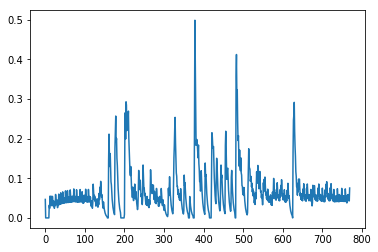

In [28]:
plt.plot(speed_raw)
np.save(MAIN_dir+'data_files/speeds_tf15.npy',speed_raw)

703.0565755208333


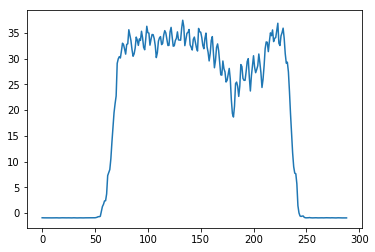

In [98]:
pred_raw = []
for x in prediction_raw:
    x = np.squeeze(x.numpy())
    pred_raw.append(x)
# print(np.asarray(pred_raw))
print(np.sum(pred_raw)/7.5)
plt.plot(pred_raw)
np.save(MAIN_dir+'data_files/log_flowtest19_raw.npy',pred_raw)

215.91456705729166


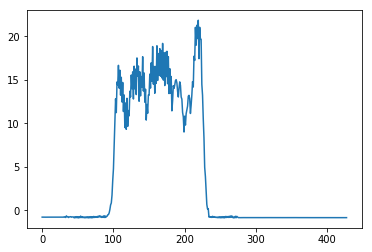

In [100]:
pred_raw = []
for x in prediction_raw:
    x = np.squeeze(x.numpy())
    pred_raw.append(x)
# print(np.asarray(pred_raw))
print(np.sum(pred_raw)/7.5)
plt.plot(pred_raw)
np.save(MAIN_dir+'data_files/log_bamb11_raw.npy',pred_raw)

In [103]:
pred_raw19 = np.load(MAIN_dir+'data_files/log_flowtest19_raw.npy')

In [104]:
cnt = 0
xxx= []
for xx in pred_raw19:
    if xx> 1:
        xxx.append(xx)
        cnt+=1
        
np.mean(xxx)

28.845495

In [16]:
signals = validate_model(model, 1, 48, validation_dataset, write_summary=False, return_losses=False, conv_out=False)

 Validation_Time (hr:mm:ss) --> 00:01:49 ,   Avg_loss: 3.0880923   Avg_accuracy: 95.3%   Overall Progress:100.0%, completed 48 out of 48 logsm

In [ ]:

signal = []
signalz = []
onehot_signals = []
volume_signal = []
cnt = 0

for sig in tqdm(signals):
    for si in sig:
        for s in si:
            sm = np.float32(np.squeeze(s.numpy()))
            signal.append(sm)
            volume_signal.append(testing_volume[cnt])
            onehot_signals.append(sm)
            cnt += 1
    signalz.append([testing_path[cnt-1].split('/')[8], testing_weight[cnt-1], testing_log_length[cnt-1], signal[:len(signal)], 
                    volume_signal[:len(volume_signal)]])
    signal.clear()
    volume_signal.clear()

In [17]:
signal = []
signalz = []
onehot_signals = []
volume_signal = []
cnt = 0

for sig in tqdm(signals):
    for si in sig:
        for s in si:
            sm = np.float32(np.squeeze(s.numpy()))
            signal.append(sm)
            volume_signal.append(validation_volume[cnt])
            onehot_signals.append(sm)
            cnt += 1
    signalz.append([validation_path[cnt-1].split('/')[8], validation_weight[cnt-1], validation_log_length[cnt-1], signal[:len(signal)], 
                    volume_signal[:len(volume_signal)]])
    signal.clear()
    volume_signal.clear()

100%|██████████| 48/48 [00:03<00:00, 14.21it/s]


In [26]:
signal = []
signalz = []
onehot_signals = []
volume_signal = []
cnt = 0

for sig in tqdm(signals):
    for si in sig:
        for s in si:
            sm = np.float32(np.squeeze(s.numpy()))
            signal.append(sm)
            volume_signal.append(training_volume[cnt])
            onehot_signals.append(sm)
            cnt += 1
    signalz.append([training_path[cnt-1].split('/')[8], training_weight[cnt-1], training_log_length[cnt-1], signal[:len(signal)], 
                    volume_signal[:len(volume_signal)]])
    signal.clear()
    volume_signal.clear()

100%|██████████| 143/143 [00:10<00:00, 13.77it/s]


In [27]:
np.save(MAIN_dir+'Signals/nbr9_ELU_train.npy', signalz)


In [21]:
signalz = np.load(MAIN_dir+'Signals/5th_nbtr9_train.npy', allow_pickle=True)

Summary
Log name: 2015_07_15_1611_bamb_3_649
Log length: 638.0
Ground Truth: 649.0 Prediction: 758.43445
MSE: 11975.898 MAE: 109.43445 Accuracy: 83.13798904418945 %


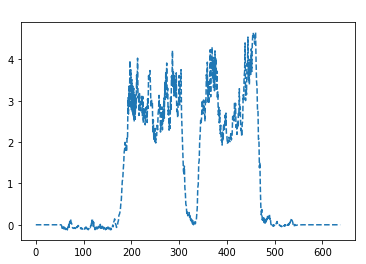

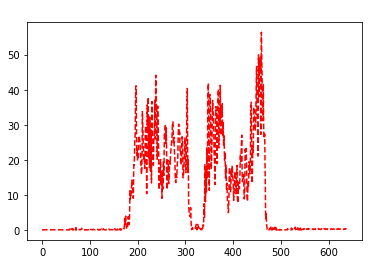

Summary
Log name: 2015_07_15_1638_bamb_4_640
Log length: 511.0
Ground Truth: 640.0 Prediction: 653.19745
MSE: 174.17265 MAE: 13.197449 Accuracy: 97.93789871037006 %


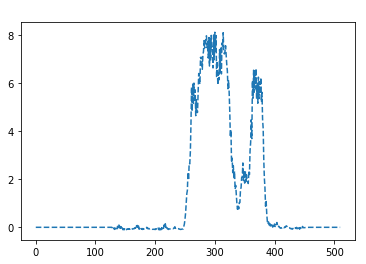

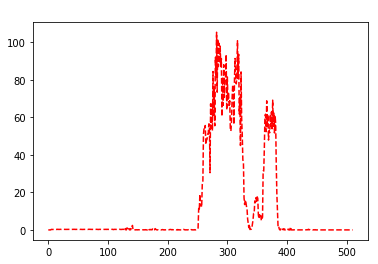

Summary
Log name: 2015_07_15_1647_bamb_5_635
Log length: 397.0
Ground Truth: 635.0 Prediction: 612.0362
MSE: 527.33636 MAE: 22.963806 Accuracy: 96.38365246355534 %


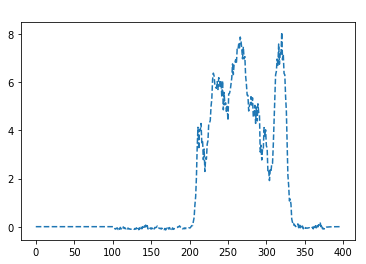

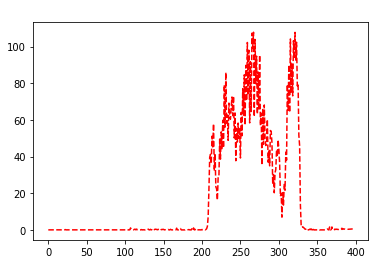

Summary
Log name: 2015_07_15_1656_bamb_6_630
Log length: 408.0
Ground Truth: 630.0 Prediction: 619.6127
MSE: 107.89661 MAE: 10.387329 Accuracy: 98.35121762007475 %


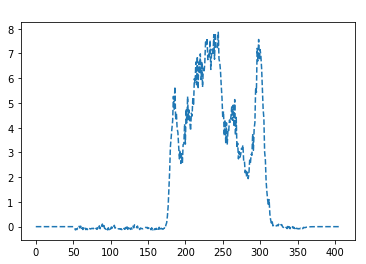

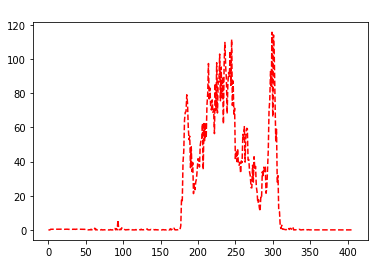

Summary
Log name: 2015_07_15_1700_bamb_7_629
Log length: 292.0
Ground Truth: 629.0 Prediction: 613.23395
MSE: 248.5684 MAE: 15.766052 Accuracy: 97.4934734404087 %


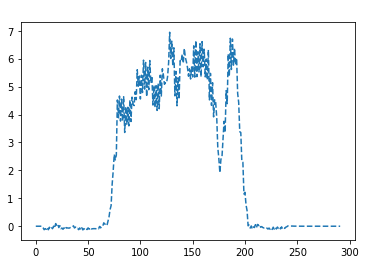

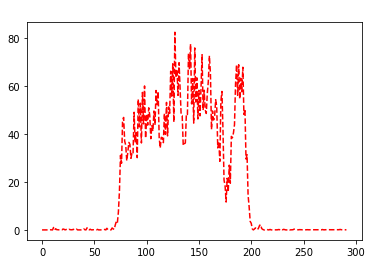

Summary
Log name: 2015_07_15_1702_bamb_8_625
Log length: 1006.0
Ground Truth: 625.0 Prediction: 522.16455
MSE: 10575.13 MAE: 102.83545 Accuracy: 83.5463285446167 %


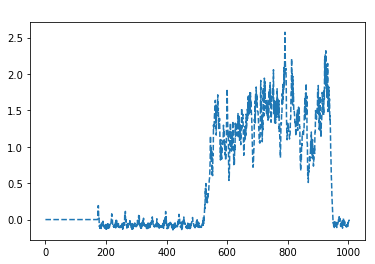

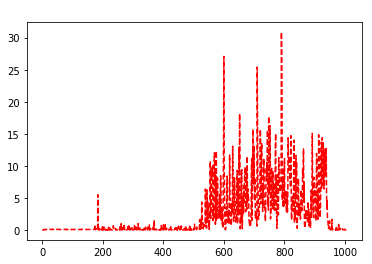

Summary
Log name: 2015_07_16_1435_bamb_9_0
Log length: 416.0
Ground Truth: 0.0 Prediction: -30.223846
MSE: 913.4809 MAE: 30.223846 Accuracy: -inf %


/home/moe/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in float_scalars
  


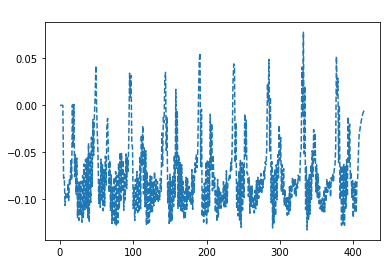

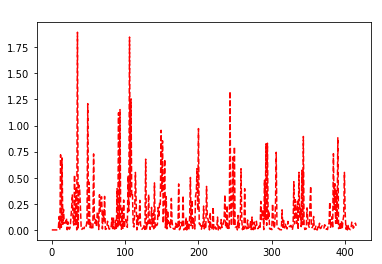

Summary
Log name: 2015_07_16_1443_bamb_10_634
Log length: 636.0
Ground Truth: 634.0 Prediction: 582.4177
MSE: 2660.7312 MAE: 51.582275 Accuracy: 91.86399430036545 %


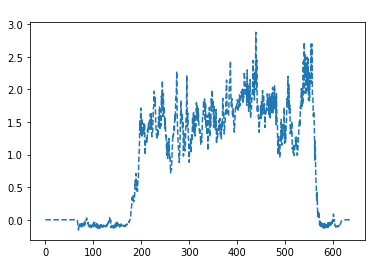

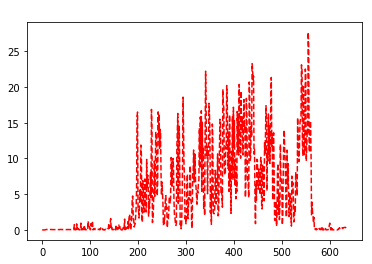

Summary
Log name: 2015_07_16_1447_bamb_11_635
Log length: 427.0
Ground Truth: 635.0 Prediction: 634.7485
MSE: 0.063265264 MAE: 0.25152588 Accuracy: 99.96038962563034 %


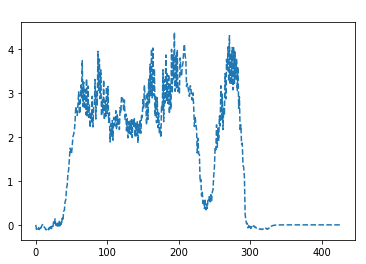

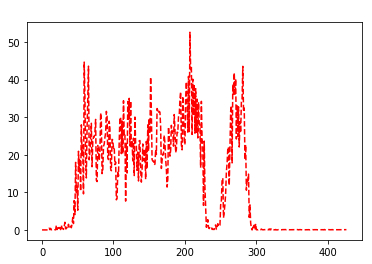

Summary
Log name: 2015_07_16_1450_bamb_12_632
Log length: 413.0
Ground Truth: 632.0 Prediction: 642.22473
MSE: 104.545135 MAE: 10.224731 Accuracy: 98.3821626752615 %


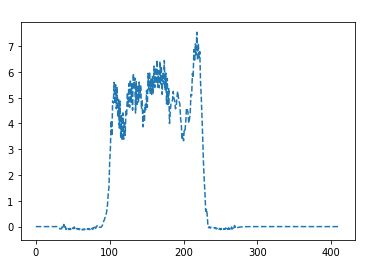

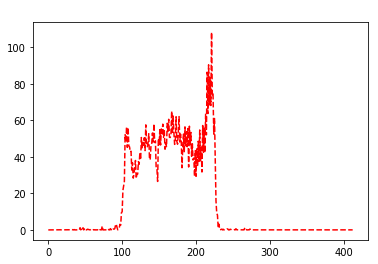

Summary
Log name: 2015_07_16_1454_bamb_13_632
Log length: 370.0
Ground Truth: 632.0 Prediction: 615.40875
MSE: 275.2695 MAE: 16.591248 Accuracy: 97.37480264157057 %


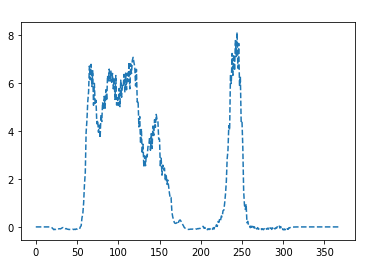

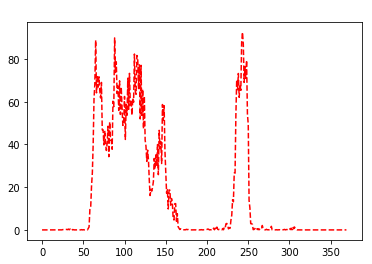

Summary
Log name: 2015_07_16_1457_bamb_14_627
Log length: 308.0
Ground Truth: 627.0 Prediction: 614.7025
MSE: 151.22815 MAE: 12.297485 Accuracy: 98.03867861628532 %


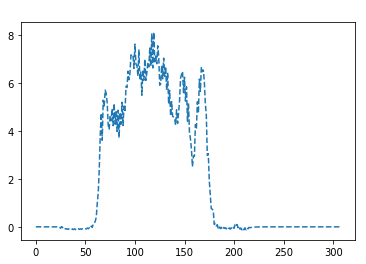

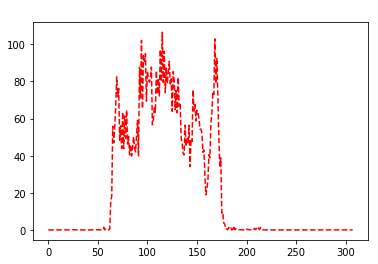

In [35]:
x = 0
for i, sig in enumerate(signalz):
    if i >= x:
        prd = np.sum(sig[3])
        gt = np.squeeze(sig[1])
        mse = np.square(gt-prd)
        mae = np.abs(gt-prd)
        ACC = (1-mae/gt)*100
        print('Summary')
        print('Log name:', sig[0])
        print('Log length:', sig[2])
        print('Ground Truth:', gt, 'Prediction:', prd)
        print('MSE:', mse, 'MAE:', mae, 'Accuracy:', ACC,'%')
        plt.title('Mass Predicted Signal', color='white')
        plt.plot(sig[3], '--')
        plt.show()
        plt.title('Volume Signal', color='white')
        plt.plot(sig[4], 'r--')
        plt.show()
    if i>(x+10):
        break
        # break

In [26]:
signalzz = np.load(MAIN_dir+'Signals/5th_nbtr9_validate.npy')

Summary
Log name: 2015_07_22_1518_bamb_87_624
Log length: 410.0
Ground Truth: 624.0 Prediction: 663.297
MSE: 1544.254 MAE: 39.296997 Accuracy: 93.70240420103073 %


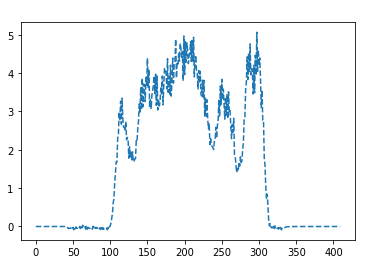

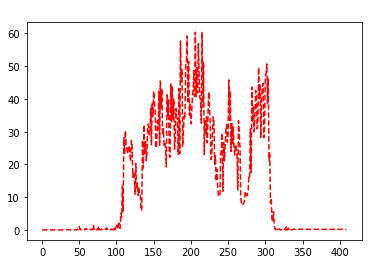

In [32]:
x = 6
for i, sig in enumerate(signalzz):
    if i>x:
        prd = np.sum(sig[3])
        gt = np.squeeze(sig[1])
        mse = np.square(gt-prd)
        mae = np.abs(gt-prd)
        ACC = (1-mae/gt)*100
        print('Summary')
        print('Log name:', sig[0])
        print('Log length:', sig[2])
        print('Ground Truth:', gt, 'Prediction:', prd)
        print('MSE:', mse, 'MAE:', mae, 'Accuracy:', ACC,'%')
        plt.title('Mass Predicted Signal', color='white')
        plt.plot(sig[3], '--')
        plt.show()
        plt.title('Volume Signal', color='white')
        plt.plot(sig[4], 'r--')
        plt.show()
    # if i>(x+10):
    #     break
        break

In [38]:
testing_path[0].split('/')[8]

'2015_07_21_1203_bamb_70_630'

In [ ]:

mn = 1
mn_idx = 0
mx = 0
mx_idx = 0
ref_mn = 0
ref_mx = 0
accuracy_mean = 0
cnt = 0
for i, acc in enumerate(Accuracy):
    if acc < mn and acc > 0.56:
        mn= acc
        mn_idx = i
        ref_mn = log_order[i]
    if acc > mx:
        mx = acc
        mx_idx = i 
        ref_mx = log_order[i]
    if acc > 0.56:
        cnt += 1
        accuracy_mean += acc
print(mn, mn_idx, ref_mn, mx, mx_idx, ref_mx, accuracy_mean/cnt*100)

In [27]:
print(len(Accuracy))

45


In [13]:
# VALIDATION CODE

logs_N = 143
start = time.time()
MAE = []
MSE = []
MSBE = []
Accuracy = []
log_order = []
signals = []
signal = []
metric_mse = []
summed_volume = 0
remainder = 0
iterations = 0
fixed_size = 0
count = 0
new_log = True
cnt_log = -1

for (batch, (images, labels, speeds, log_length)) in enumerate(train_dataset):
        batch += 1
        if new_log:           
            new_log = False
            length = int(log_length[0].numpy() - fixed_size + remainder)
            iterations = int(np.floor(length/Batch_size))
            remainder = int(np.mod(length, Batch_size))
            fixed_size = np.shape(speeds)[0]
            cnt_log += 1
        
        if count < iterations:
            mass_pred = model(images)
            volume = (mass_pred * speeds) * t
            summed_volume += tf.reduce_sum(volume)
            mass = summed_volume.numpy()
            count = count + 1
            signal.append(volume)
            # Compute loss and Apply Gradients
            if count == iterations and remainder == 0:
                loss_unsigned = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
                loss_outlier = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L1').numpy())
                loss_signed = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction').numpy())
                MSE.append(loss_unsigned)
                MAE.append(loss_outlier)
                MSBE.append(loss_signed)
                signals.append(signal[0:len(signal)])
                signal.clear()
                
                GT = np.squeeze(labels[0].numpy())
                if GT >= 200 and GT != 501:  # used for testing
                    metric_mse.append(loss_unsigned)
                    if mass > GT:
                        log_acc = np.squeeze(GT/mass)
                    else:
                        log_acc = np.squeeze(mass/GT)
                    Accuracy.append(log_acc)
                    log_order.append(np.squeeze(log_length[0].numpy()))
                    time_ = time.time() - start
                    validation_progress(cnt_log, logs_N, time_, np.mean(metric_mse), np.mean(Accuracy))

                # Reset

                summed_volume = 0
                count = 0
                fixed_size = 0
                new_log = True
        # Handle the remainder from iterations
        else:
            # Compute and Aggregate the remainder Gradients
            mass_pred = model(images[0:remainder])
            volume = (mass_pred * speeds[0:remainder]) * t
            summed_volume += tf.reduce_sum(volume)
            mass = summed_volume.numpy()
            signal.append(volume)
            loss_unsigned = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L2').numpy())
            loss_outlier = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='L1').numpy())
            loss_signed = np.squeeze(compute_loss(summed_volume, labels[0], log_length[0], operation='Subtraction').numpy())
            MSE.append(loss_unsigned)
            MAE.append(loss_outlier)
            MSBE.append(loss_signed)
            signals.append(signal[0:len(signal)])
            signal.clear()

            GT = np.squeeze(labels[0].numpy())
            if GT >= 200 and GT != 501:  # used for testing
                metric_mse.append(loss_unsigned)
                if mass > GT:
                    log_acc = np.squeeze((GT+1)/(mass+1))
                else:
                    log_acc = np.squeeze((mass+1)/(GT+1))
                Accuracy.append(log_acc)
                log_order.append(np.squeeze(log_length[0].numpy()))
                time_ = time.time() - start
                validation_progress(cnt_log, logs_N, time_, np.mean(metric_mse), np.mean(Accuracy))        
                
            summed_volume = 0
            count = 0
            new_log = True
            
            # Handle gradients for the next log
            if cnt_log != logs_N-1:    
                mass_pred = model(images[remainder:])
                volume = (mass_pred * speeds[remainder:]) * t
                summed_volume += tf.reduce_sum(volume)
                signal.append(volume)



 Validation_Time (hr:mm:ss) --> 00:00:28 ,   Avg_loss: 8.362145   Avg_accuracy: 93.0%   Overall Progress:9.1%, completed 13 out of 143 logsm

KeyboardInterrupt: 

In [ ]:
# OTHER ACCURACY MEASURE
def accuracy_err(prediction, label):
    accuracy = []
    for i, prd in enumerate(prediction):
        if tf.abs(prd).numpy() > tf.abs(label[i]).numpy():
            acc = np.squeeze(tf.abs(tf.divide(label[i], prd)).numpy())
            if acc != acc:
                acc = 0
            accuracy.append(acc)
        else: 
            acc = np.squeeze(tf.abs(tf.divide(prd, label[i])).numpy())
            if acc != acc:
                acc = 0
            accuracy.append(acc)
    return accuracy

In [ ]:
loss_ = 0
train_N = 57
mass = 0
err = 0
acm_accu = 0
max_acc = 0
min_acc = 1
start = time.time()
aggregated = []
for epoch in range(1):
    
    summed_volume = 0
    remainder = 0
    iterations = 0
    fixed_size = 0
    count = 0
    new_log = True
    append_flag = True
    next_log = False
    cnt_log = -1
    first_run = True
    for (batch, (images, labels, speeds, log_length)) in enumerate(test_dataset):
        batch += 1
        step = tf.train.get_or_create_global_step()
        if new_log:           
            new_log = False
            length = int(log_length[0].numpy() - fixed_size + remainder)
            iterations = int(np.floor(length/Batch_size))
            remainder = int(np.mod(length, Batch_size))
            fixed_size = np.shape(speeds)[0]
            cnt_log += 1
            # print(log_length[0], iterations, fixed_size, remainder)


        if count < iterations:
            mass_pred = model(images)
            volume = (mass_pred * speeds) * t
            if cnt_log ==0:
                print(volume)
            mass += tf.reduce_sum(volume).numpy()
        
            labels = tf.to_float(labels)
            accuracy = accuracy_err(volume, labels)
        
            # print(batch)
            if np.max(accuracy) > max_acc:
                max_acc = np.max(accuracy)
            elif np.min(accuracy) <  min_acc:
                min_acc = np.min(accuracy)
            acm_accu += np.sum(accuracy)


            count = count + 1

            # Compute loss and Apply Gradients
            if count == iterations and remainder == 0:
                avg_acc = acm_accu / log_length[0].numpy()
                # print(mass)
                if mass > labels[0].numpy():
                    log_acc = np.squeeze(labels[0].numpy()/mass)
                else:
                    log_acc = np.squeeze(mass/labels[0].numpy())
                print("Accuracy per log: {:.3%}\nAverage Accuracy per batch: {:.3%}\nMax accuracy per batch: {:.3%}\nMin accuracy per batch: {:.3%} "
                      "\n\n".format(
                    log_acc, avg_acc, max_acc, min_acc))

                # Reset
                summed_volume = 0
                count = 0
                append_flag = True
                fixed_size = 0
                new_log = True
                mass = 0
        # Handle the remainder from iterations
        else:
            # Compute and Aggregate the remainder Gradients
            mass_pred = model(images[0:remainder])
            volume = (mass_pred * speeds[0:remainder]) * t
            if cnt_log == 0:
                print(volume)
            mass += tf.reduce_sum(volume).numpy()
        
            labels = tf.to_float(labels)
            accuracy = accuracy_err(volume, labels)
        
            # print(batch)
            if np.max(accuracy) > max_acc:
                max_acc = np.max(accuracy)
            elif np.min(accuracy) <  min_acc:
                min_acc = np.min(accuracy)
            acm_accu += np.sum(accuracy)

            avg_acc = acm_accu / log_length[0].numpy()
            print(mass)
            if mass > labels[0].numpy():
                log_acc = np.squeeze(labels[0].numpy()/mass)
            else:
                log_acc = np.squeeze(mass/labels[0].numpy())
            print("Accuracy per log: {:.3%}\nAverage Accuracy per batch: {:.3%}\nMax accuracy per batch: {:.3%}\nMin accuracy per batch: {:.3%} \n\n".format(
                log_acc, avg_acc, max_acc, min_acc))
            

            summed_volume = 0
            count = 0
            append_flag = True
            new_log = True
            mass = 0
            
            # Handle gradients for the next log
            if cnt_log != train_N-1:
                
                mass_pred = model(images[remainder:])
                volume = (mass_pred * speeds[remainder:]) * t
                # print(volume)
                mass += tf.reduce_sum(volume).numpy()
            
                labels = tf.to_float(labels)
                accuracy = accuracy_err(volume, labels)
            
                # print(batch)
                if np.max(accuracy) > max_acc:
                    max_acc = np.max(accuracy)
                elif np.min(accuracy) <  min_acc:
                    min_acc = np.min(accuracy)
                acm_accu += np.sum(accuracy)

